In [2]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def show_PIL_image(image):
    if(len(image.shape) < 3):
        image = image.unsqueeze(0)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


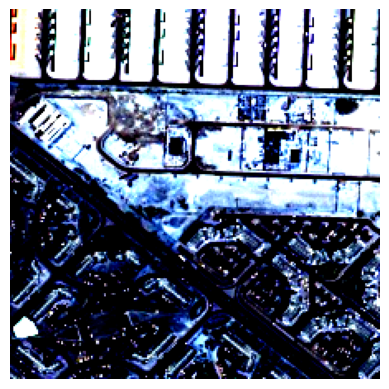

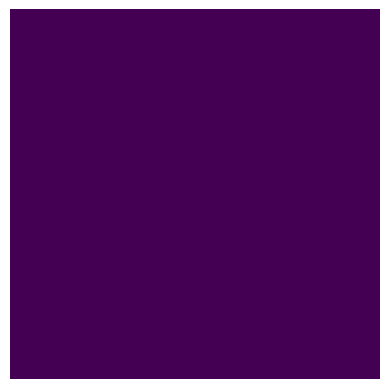

In [4]:
from Modules.ultis import DubaiAerialread
import albumentations as A
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

trans = transforms.ToTensor()

transforms_img = A.Compose([
    A.RandomResizedCrop(256, 256),  # Random crop and resize
    A.HorizontalFlip(),  # Random horizontal flip
    A.VerticalFlip(),  # Random vertical flip
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),  # Convert to tensor
])

transforms_mask = transforms.Compose([
    transforms.RandomResizedCrop(size=(256, 256)),  # Random crop and resize
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.ToTensor(),  # Convert to tensor
])

dataset = DubaiAerialread(data_path='data/Semantic segmentation dataset', transform=None)

image, mask = dataset[10]

show_PIL_image(image)
show_PIL_image(mask)